In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 16 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_16____2020_08_09_21_58_11_099843_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

In [13]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [14]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [15]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [16]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 2.6292 - accuracy: 0.0688 - val_loss: 20.8323 - val_accuracy: 0.1522
Epoch 2/500
2/2 [==============================] - 2s 781ms/step - loss: 2.2548 - accuracy: 0.1625 - val_loss: 17.3784 - val_accuracy: 0.1203
Epoch 3/500
2/2 [==============================] - 1s 747ms/step - loss: 2.1682 - accuracy: 0.2688 - val_loss: 15.6162 - val_accuracy: 0.1220
Epoch 4/500
2/2 [==============================] - 2s 763ms/step - loss: 2.0729 - accuracy: 0.2750 - val_loss: 14.4714 - val_accuracy: 0.1196
Epoch 5/500
2/2 [==============================] - 2s 776ms/step - loss: 2.1317 - accuracy: 0.3063 - val_loss: 13.5951 - val_accuracy: 0.1259
Epoch 6/500
2/2 [==============================] - 2s 773ms/step - loss: 2.0842 - accuracy: 0.3000 - val_loss: 12.7771 - val_accuracy: 0.1185
Epoch 7/500
2/2 [==============================] - 2s 751ms/step - loss: 2.0058 - accuracy: 0.3500 - val_loss: 12.5139 - val_accuracy: 0.1026
Epoch 8/5

Epoch 59/500
2/2 [==============================] - 2s 757ms/step - loss: 1.1488 - accuracy: 0.9250 - val_loss: 3.6061 - val_accuracy: 0.2424
Epoch 60/500
2/2 [==============================] - 2s 790ms/step - loss: 1.1636 - accuracy: 0.9000 - val_loss: 3.5595 - val_accuracy: 0.2478
Epoch 61/500
2/2 [==============================] - 2s 764ms/step - loss: 1.1651 - accuracy: 0.8938 - val_loss: 3.5485 - val_accuracy: 0.2470
Epoch 62/500
2/2 [==============================] - 2s 760ms/step - loss: 1.1471 - accuracy: 0.9312 - val_loss: 3.5660 - val_accuracy: 0.2442
Epoch 63/500
2/2 [==============================] - 2s 783ms/step - loss: 1.1241 - accuracy: 0.9563 - val_loss: 3.6550 - val_accuracy: 0.2378
Epoch 64/500
2/2 [==============================] - 2s 758ms/step - loss: 1.1434 - accuracy: 0.9312 - val_loss: 3.7082 - val_accuracy: 0.2328
Epoch 65/500
2/2 [==============================] - 2s 755ms/step - loss: 1.1206 - accuracy: 0.9375 - val_loss: 3.7383 - val_accuracy: 0.2291
Epoch 

2/2 [==============================] - 2s 762ms/step - loss: 0.9901 - accuracy: 0.9937 - val_loss: 3.2335 - val_accuracy: 0.2423
Epoch 117/500
2/2 [==============================] - 2s 760ms/step - loss: 0.9833 - accuracy: 1.0000 - val_loss: 3.2020 - val_accuracy: 0.2491
Epoch 118/500
2/2 [==============================] - 2s 781ms/step - loss: 0.9818 - accuracy: 0.9937 - val_loss: 3.1509 - val_accuracy: 0.2553
Epoch 119/500
2/2 [==============================] - 2s 754ms/step - loss: 0.9872 - accuracy: 0.9937 - val_loss: 3.1053 - val_accuracy: 0.2595
Epoch 120/500
2/2 [==============================] - 2s 758ms/step - loss: 0.9828 - accuracy: 0.9937 - val_loss: 3.0854 - val_accuracy: 0.2587
Epoch 121/500
2/2 [==============================] - 2s 794ms/step - loss: 0.9903 - accuracy: 0.9937 - val_loss: 3.0776 - val_accuracy: 0.2586
Epoch 122/500
2/2 [==============================] - 2s 757ms/step - loss: 0.9878 - accuracy: 0.9875 - val_loss: 3.0911 - val_accuracy: 0.2587
Epoch 123/500

2/2 [==============================] - 2s 757ms/step - loss: 0.9390 - accuracy: 1.0000 - val_loss: 3.2813 - val_accuracy: 0.2241
Epoch 174/500
2/2 [==============================] - 2s 757ms/step - loss: 0.9504 - accuracy: 1.0000 - val_loss: 3.2785 - val_accuracy: 0.2181
Epoch 175/500
2/2 [==============================] - 2s 775ms/step - loss: 0.9560 - accuracy: 0.9937 - val_loss: 3.2578 - val_accuracy: 0.2164
Epoch 176/500
2/2 [==============================] - 1s 749ms/step - loss: 0.9566 - accuracy: 0.9875 - val_loss: 3.2106 - val_accuracy: 0.2223
Epoch 177/500
2/2 [==============================] - 2s 766ms/step - loss: 0.9520 - accuracy: 1.0000 - val_loss: 3.1330 - val_accuracy: 0.2331
Epoch 178/500
2/2 [==============================] - 2s 754ms/step - loss: 0.9477 - accuracy: 1.0000 - val_loss: 3.0806 - val_accuracy: 0.2413
Epoch 179/500
2/2 [==============================] - 2s 772ms/step - loss: 0.9401 - accuracy: 1.0000 - val_loss: 3.0560 - val_accuracy: 0.2461
Epoch 180/500

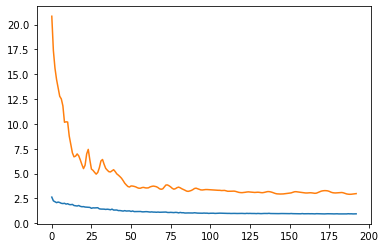

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

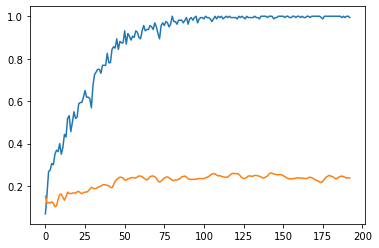

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [19]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [20]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 22:03:39 2020 Finding Nearest Neighbors
Sun Aug  9 22:03:39 2020 Building RP forest with 15 trees
Sun Aug  9 22:03:40 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Sun Aug  9 22:03:50 2020 Finished Nearest Neighbor Search
Sun Aug  9 22:03:52 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 22:04:17 2020 Finished embedding


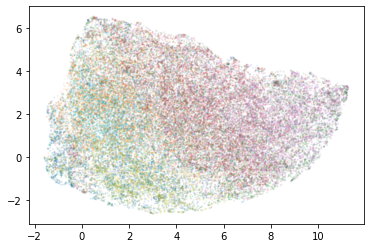

In [21]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 22:04:23 2020 Finding Nearest Neighbors
Sun Aug  9 22:04:23 2020 Building RP forest with 10 trees
Sun Aug  9 22:04:23 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Sun Aug  9 22:04:24 2020 Finished Nearest Neighbor Search
Sun Aug  9 22:04:24 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  9 22:04:40 2020 Finished embedding


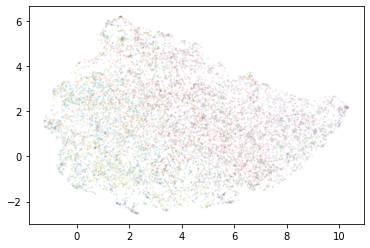

In [22]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

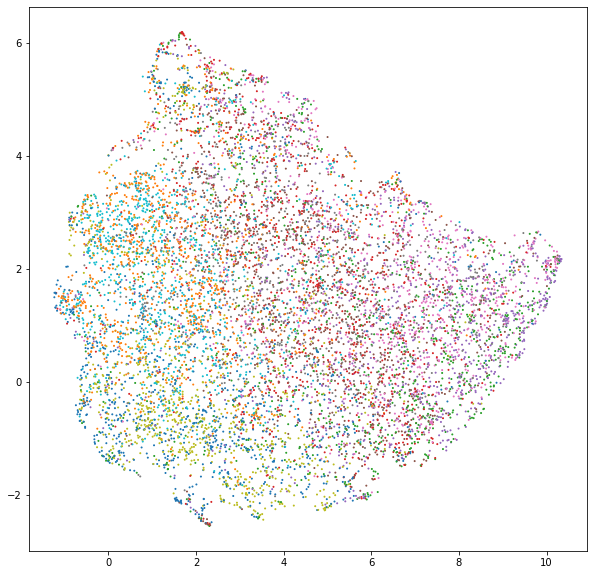

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [24]:
predictions = model.predict(X_valid)

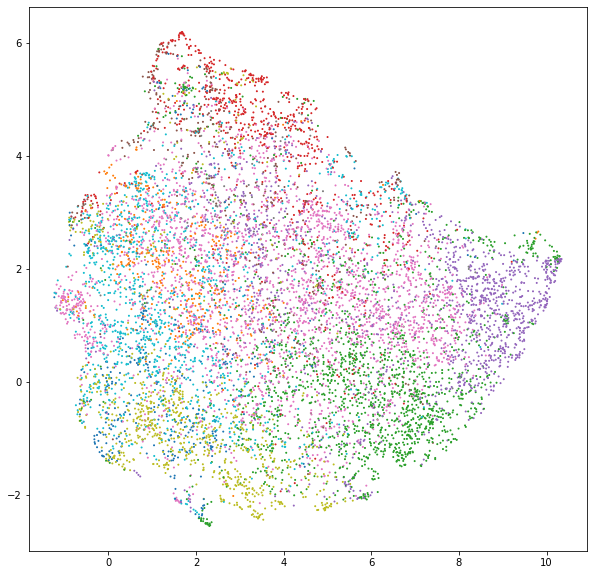

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [26]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 12s 38ms/step - loss: 2.9843 - accuracy: 0.2335


### save results

In [27]:
# save score, valid embedding, weights, results

In [28]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [29]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [30]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [31]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [32]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [33]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [34]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 11ms/step - loss: 2.9843 - accuracy: 0.2335


In [35]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:29:12 2020 Finding Nearest Neighbors
Mon Aug 10 09:29:12 2020 Building RP forest with 15 trees
Mon Aug 10 09:29:13 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Mon Aug 10 09:29:15 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:29:15 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:30:13 2020 Finished embedding


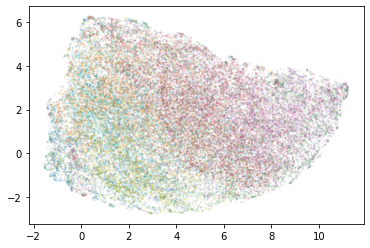

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)